In [404]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss
from sklearn.model_selection import train_test_split
import importlib
import pytorch_gradient_boosting
importlib.reload(pytorch_gradient_boosting)
from pytorch_gradient_boosting import PyTorchGradientBoosting

In [405]:
data = pd.read_csv("../data/HR.csv")
data = data.rename(columns={"sales": "department"})
data = pd.get_dummies(data)
categorical = ['department_IT', 'department_RandD', 'department_accounting', 'department_hr', 
                'department_management', 'department_marketing', 'department_product_mng', 
                'department_sales', 'department_support', 'department_technical', 
                'salary_high', 'salary_low', 'salary_medium']
data[categorical] = data[categorical].astype(float)


y = data['left']
X = data.drop(columns=['left'])
numerical = X.columns.difference(categorical)
feature_names = X.columns.tolist()

# Split the data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

print("Training set size:", X_train.shape[0])
print("Validation set size:", X_val.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 9599
Validation set size: 2400
Test set size: 3000


In [406]:
# Initialize and train the model
model = PyTorchGradientBoosting(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    random_state=42,
    reg_lambda=1.0,
    reg_alpha=0.1,
    class_weight='balanced'
)

# Train the model with early stopping
model.fit(
    X_train.values, 
    y_train.values,
    eval_set=(X_val.values, y_val.values),
    early_stopping_rounds=50,
    verbose=True
)


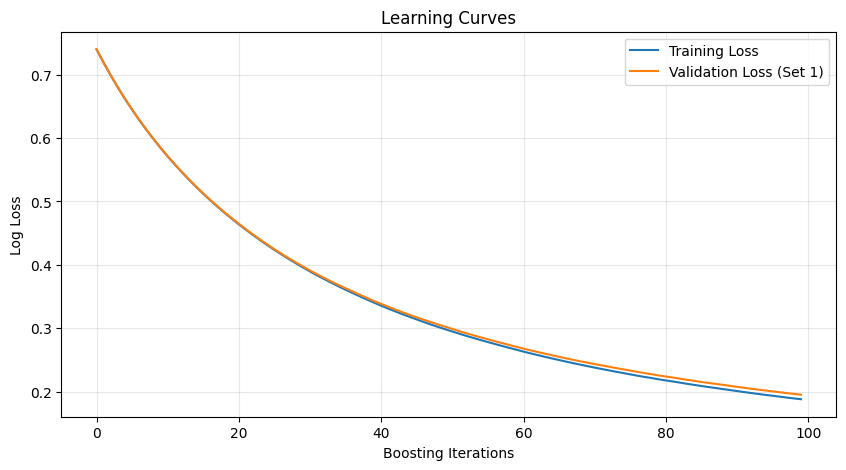

In [407]:
model.plot_learning_curve()

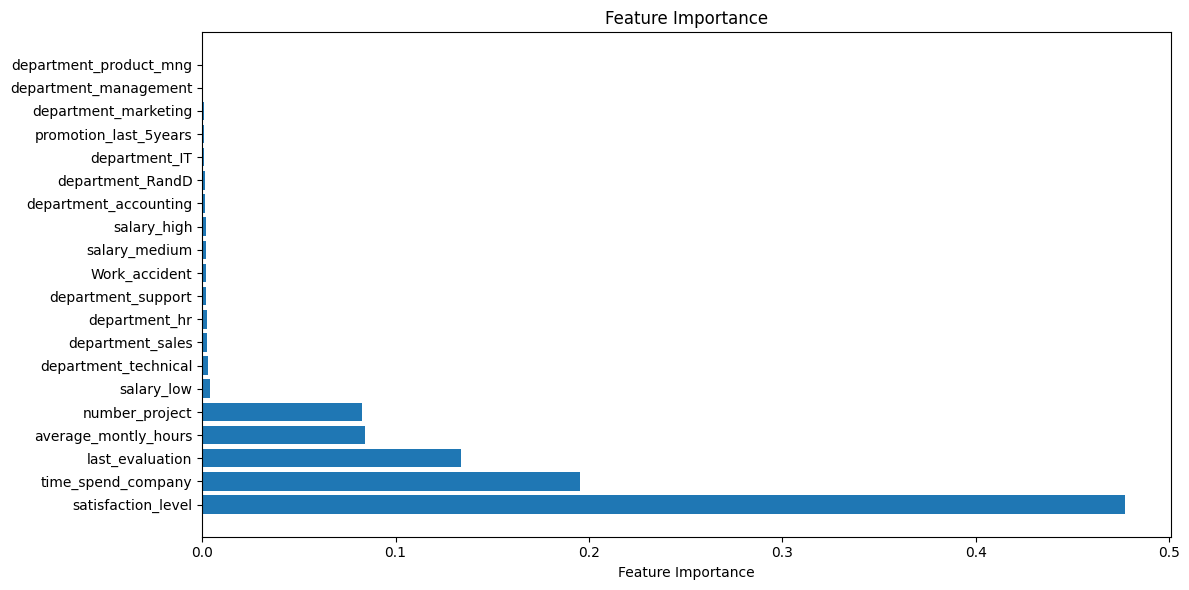

In [408]:
model.plot_feature_importance(feature_names)

In [409]:
# Make predictions on test set
y_pred_proba = model.predict_proba(X_test.values)
y_pred = model.predict(X_test.values)

# Convert PyTorch tensors to numpy for scikit-learn metrics
y_pred_proba_np = y_pred_proba.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()

# Evaluate model
print("\nTest Set Evaluation:")
print(f"AUC: {roc_auc_score(y_test, y_pred_proba_np):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred_np):.4f}")
print(f"Log Loss: {log_loss(y_test, y_pred_proba_np):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_np):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_np):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_np):.4f}")


Test Set Evaluation:
AUC: 0.9904
Accuracy: 0.9757
Log Loss: 0.1994
Precision: 0.9495
Recall: 0.9482
F1 Score: 0.9488


In [410]:
best_threshold, best_score, threshold_metrics = model.calibrate_threshold(X_val.values, y_val.values, metric='f1')
print(f"\nBest threshold: {best_threshold:.4f}")
print(f"Best f1 score: {best_score:.4f}")
final_preds = (y_pred_proba_np >= best_threshold).astype(int)
print(f"Final accuracy with best threshold: {accuracy_score(y_test, final_preds):.4f}")


Best threshold: 0.5700
Best f1 score: 0.9573
Final accuracy with best threshold: 0.9750


c:\Users\ferna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ferna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ferna\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

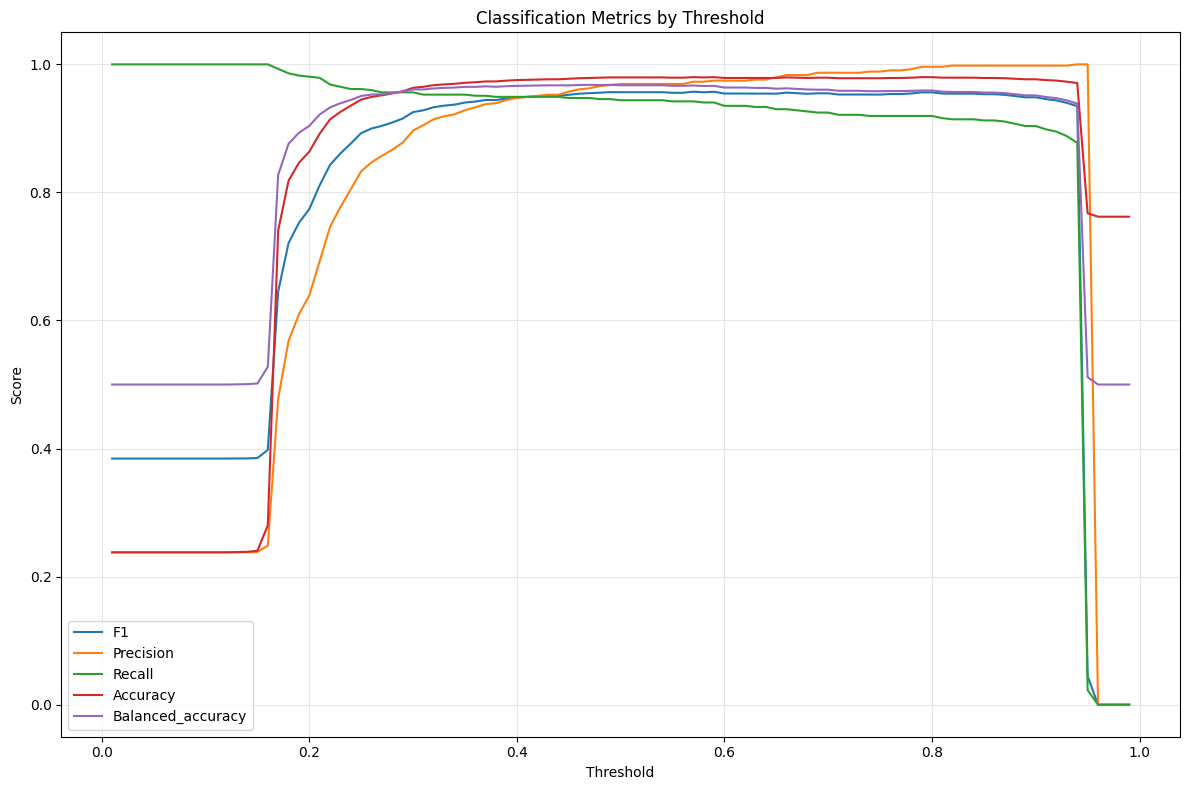

In [411]:
model.plot_threshold_metrics(threshold_metrics) 

In [412]:
#model.save_model("xgboost.pth")


  0%|          | 0/100 [00:00<?, ?it/s]

feature values [0.76 0.42 0.65 0.83 0.45 0.68 0.62 0.66 0.43 0.6  0.99 0.62 0.98 0.37
 0.69 0.45 0.74 0.69 0.87 0.42 0.87 0.71 0.62 0.1  0.85 0.74 0.82 0.43
 0.57 0.61 0.68 0.49 0.3  0.82 0.5  0.43 0.75 0.98 0.96 0.73 0.98 0.74
 0.1  0.67 0.8  0.8  0.75 0.53 0.91 0.57 0.96 0.96 0.39 0.63 0.67 0.1
 0.92 0.9  0.91 0.98 0.12 0.84 0.84 0.94 0.14 0.69 0.54 0.85 0.76 0.59
 0.65 0.7  0.38 0.75 0.32 0.98 0.89 0.65 0.45 0.52 0.86 0.82 0.11 0.82
 0.33 0.37 0.74 0.62 0.28 0.76 0.53 0.38 0.37 0.59 0.91 0.81 0.29 0.73
 1.   0.56]
shap impact .values =
array([-0.05711923,  0.01523717, -0.0800894 , -0.06790787,  0.21763152,
       -0.08291852, -0.0781882 , -0.06253712,  0.21219233, -0.07065042,
       -0.08562251, -0.06519169, -0.08614933,  0.21582663, -0.07486336,
        0.21978376, -0.01544902, -0.06064536, -0.05913139,  0.20750287,
       -0.06446407, -0.08785556, -0.0623988 ,  0.22114461,  0.04899702,
       -0.06724724, -0.04679048,  0.21335397, -0.05170788, -0.0383857 ,
       -0.0945198 ,  0.

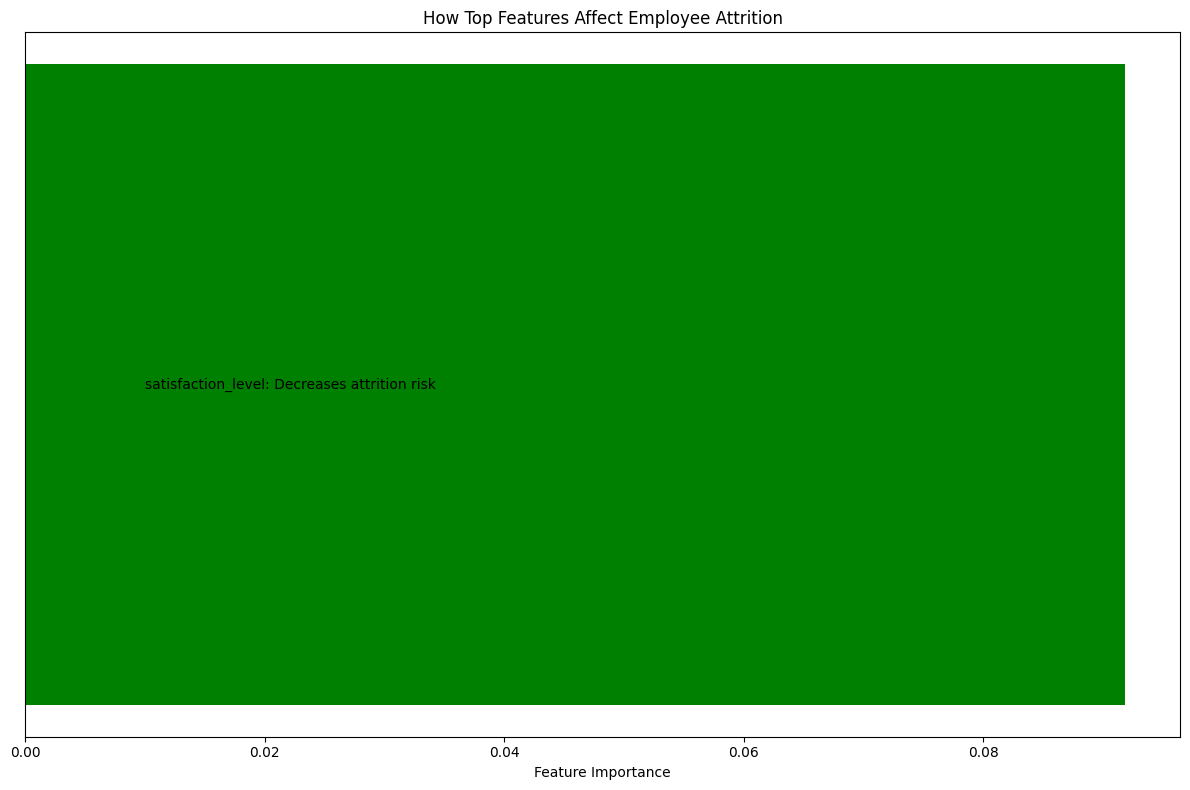

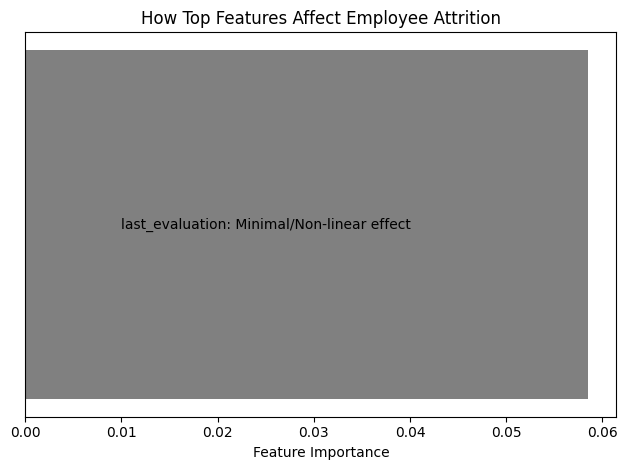

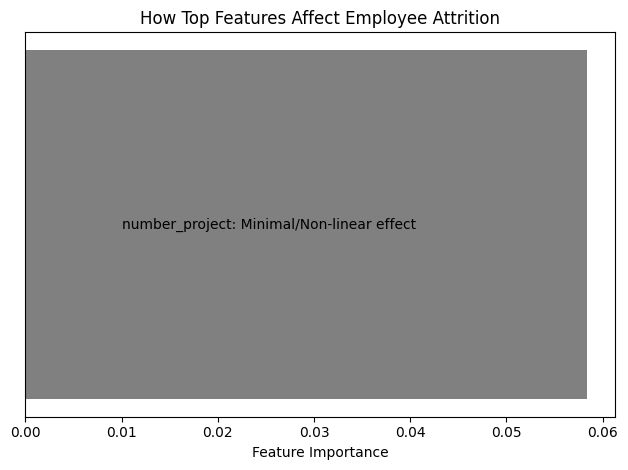

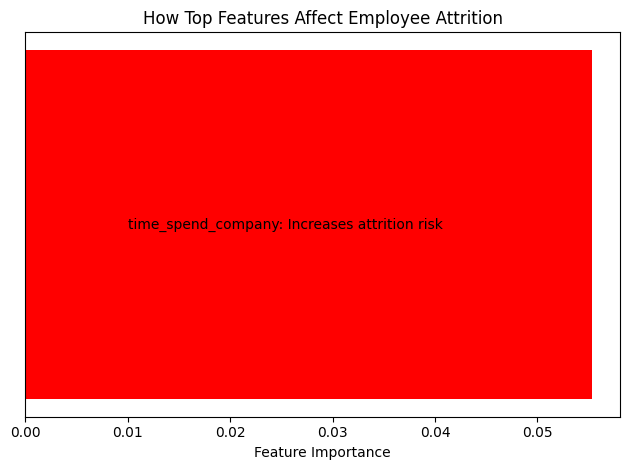

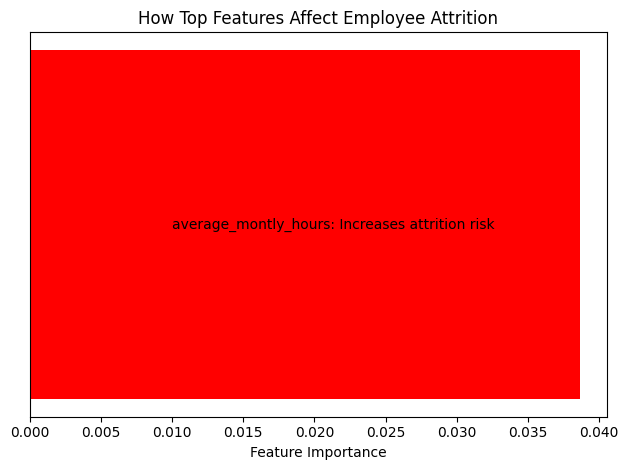

c:\Users\ferna\pccube\employee_retention\employee-retention-predictive-model\xgboost_pytorch\pytorch_gradient_boosting.py:805: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


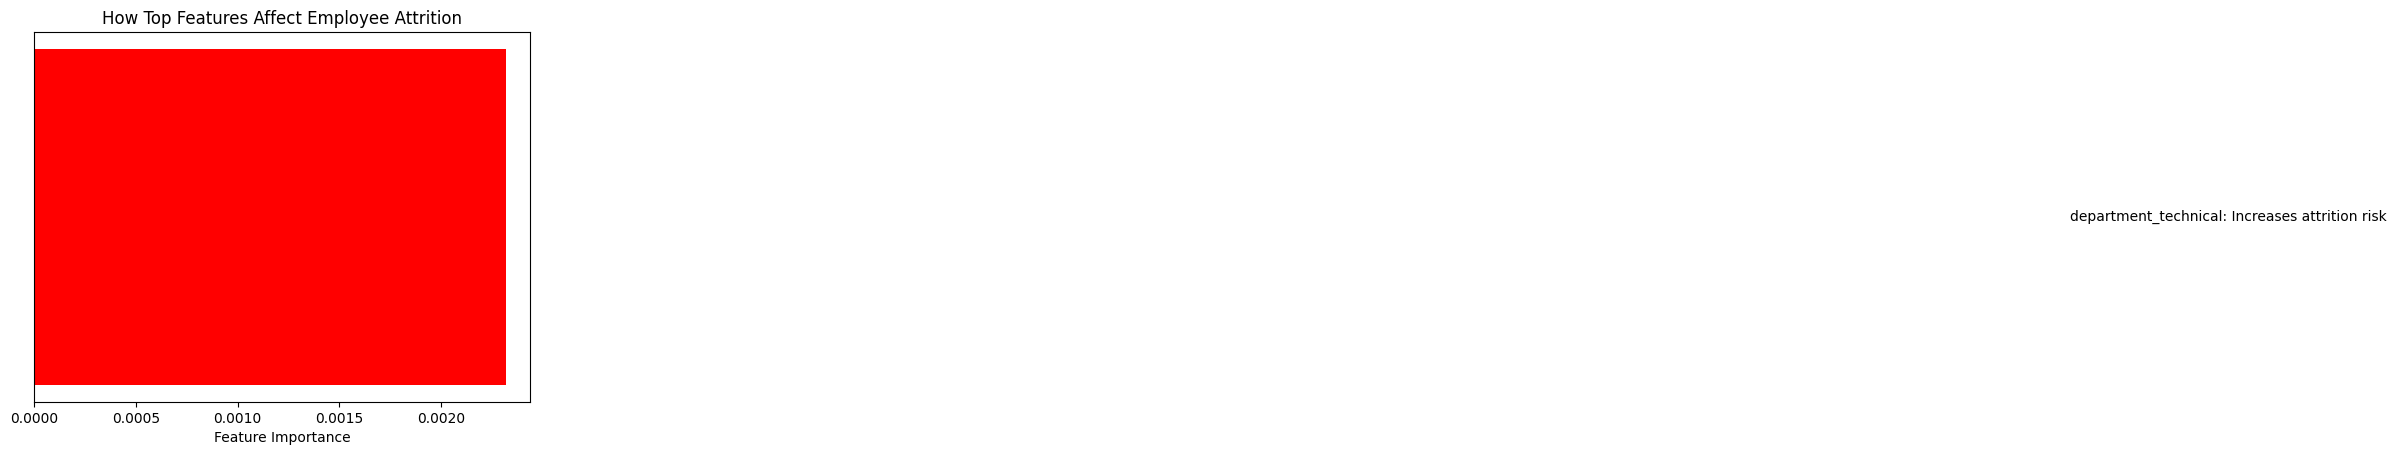

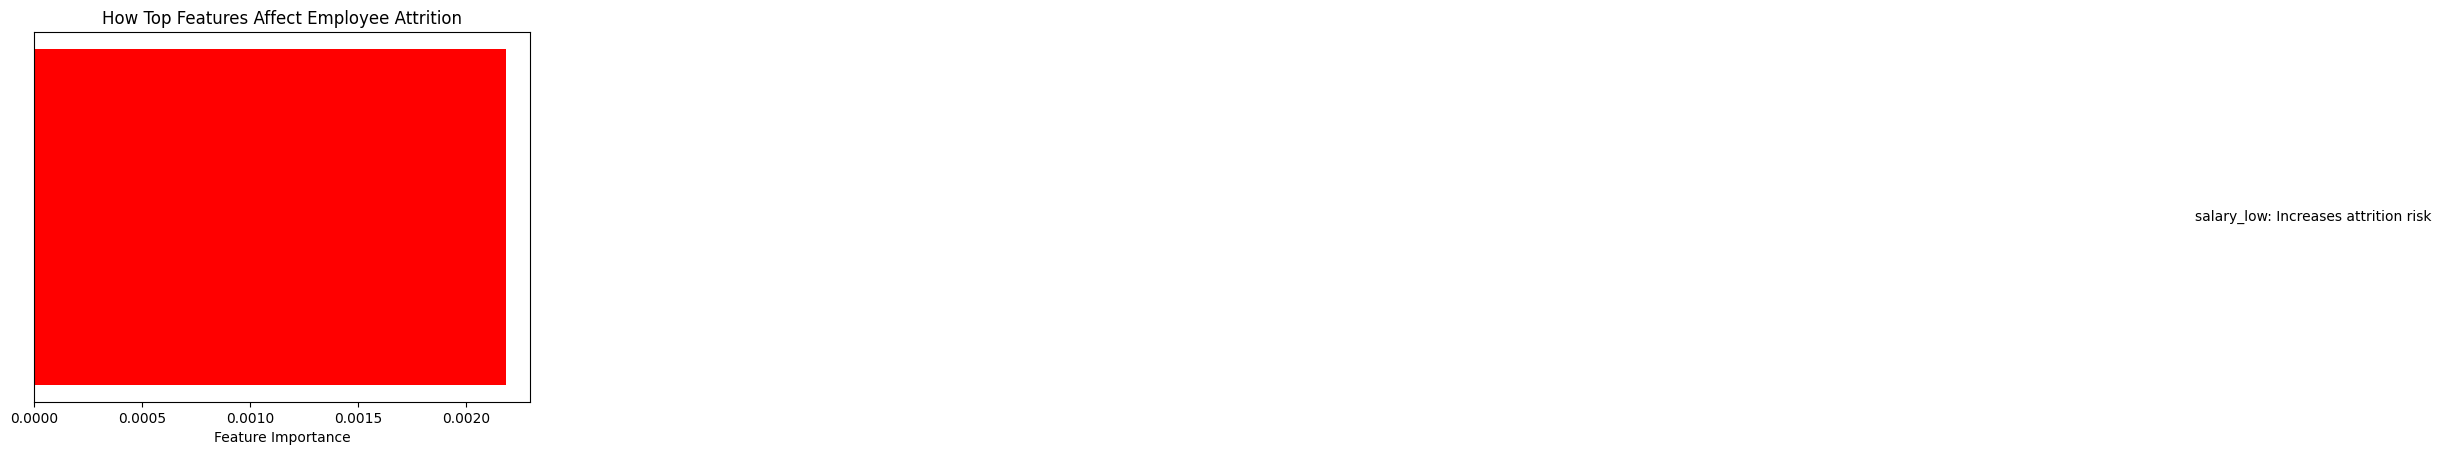

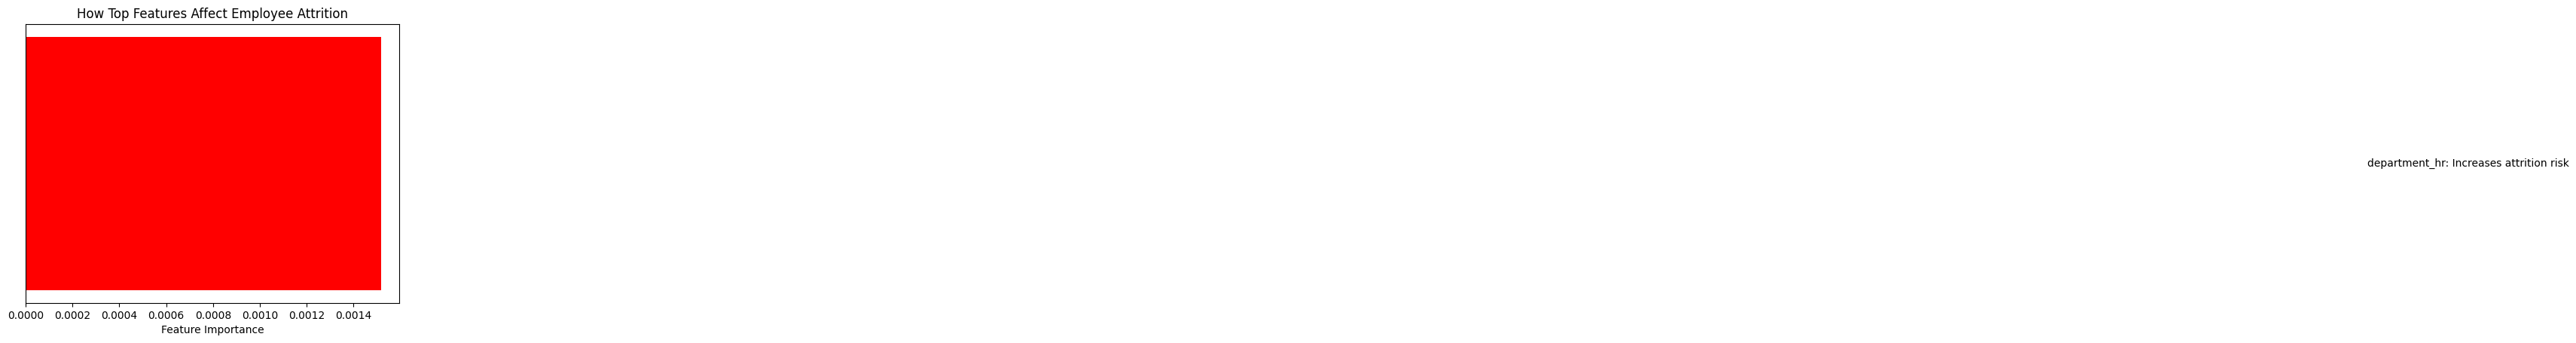

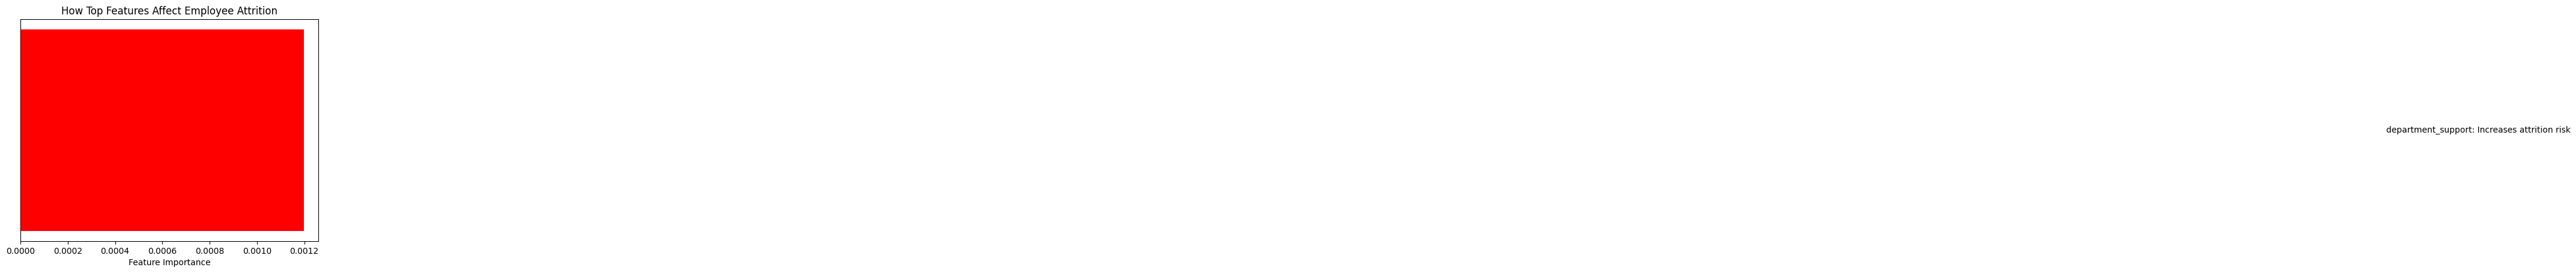

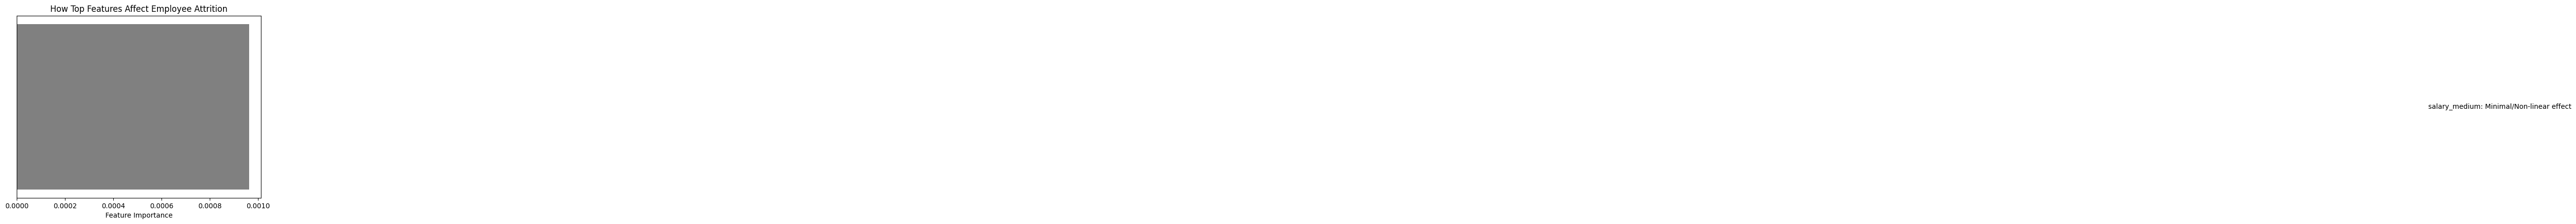

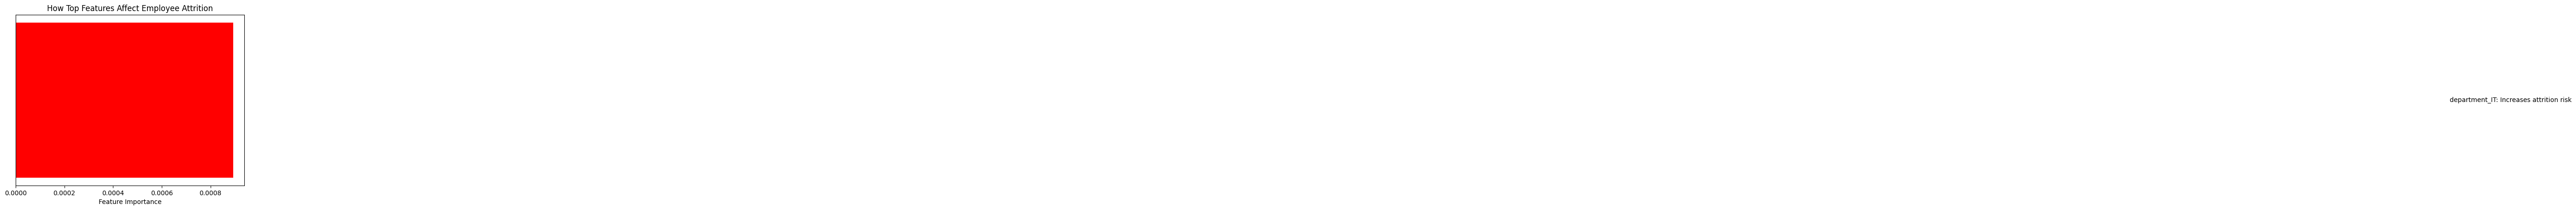

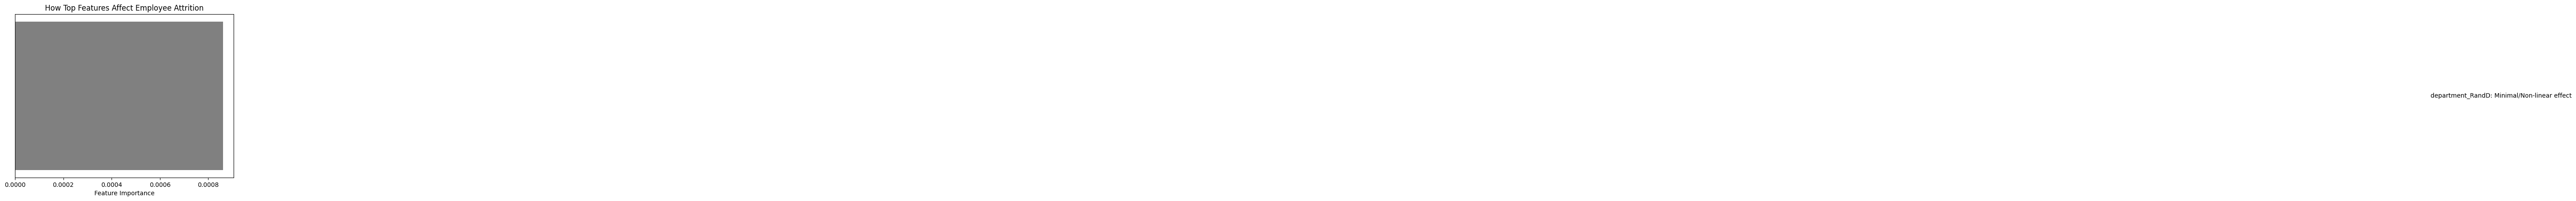

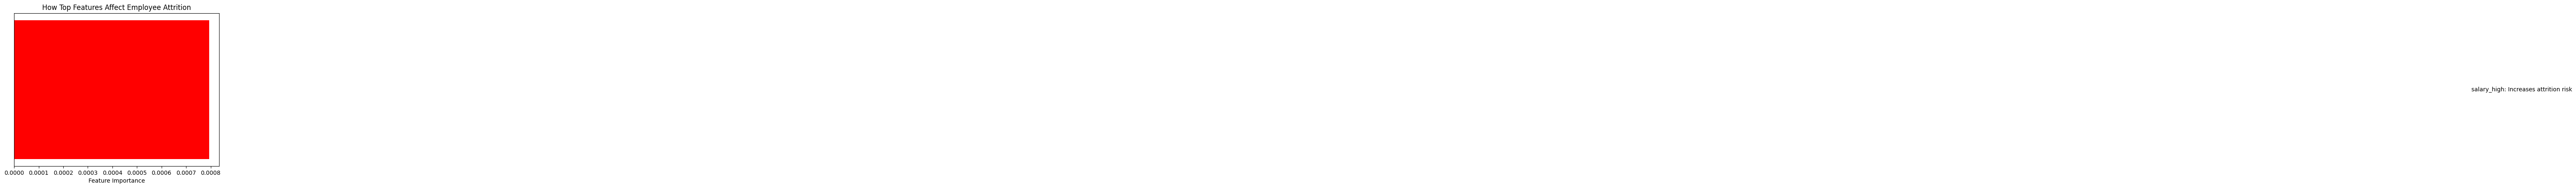

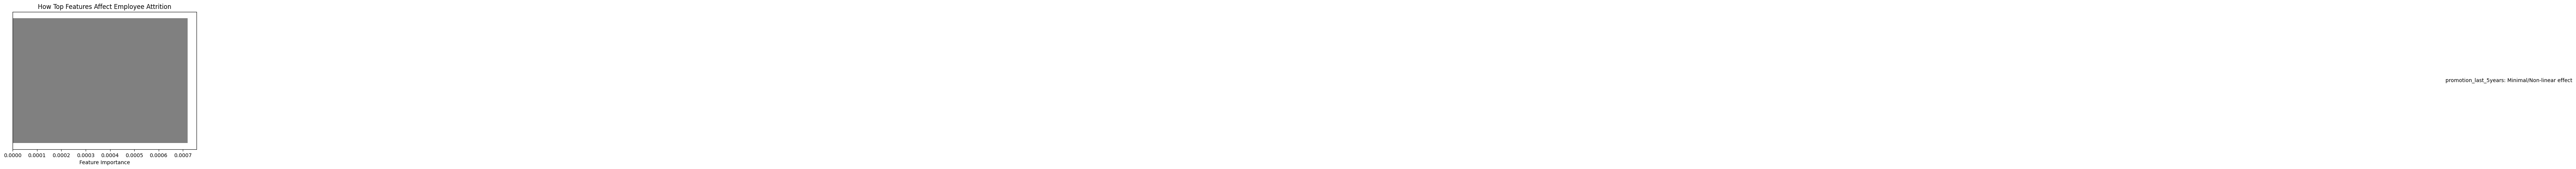

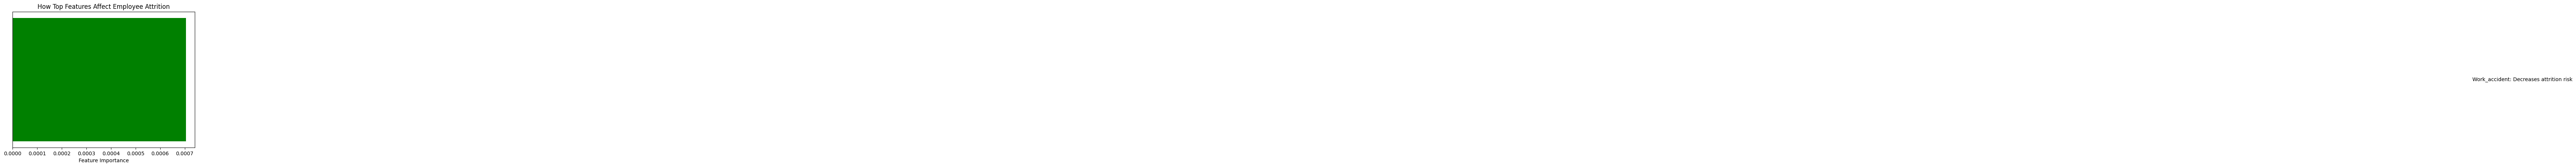

TypeError: 'NoneType' object is not subscriptable

In [414]:
import torch
# Choose a specific employee to explain (e.g., index 5 from test set)
employee_features = X_test.sample(100)
# Get explanation with SHAP
explanation = model.explain_prediction(
    torch.tensor(employee_features.values).numpy(), 
    feature_names=feature_names,
    plot=True  # This generates SHAP visualizations
)

print(f"Employee prediction: {explanation['prediction']:.4f}")
print(f"Classification: {explanation['label']}")
print("\nTop influential features:")
for feature in explanation['top_features']:
    direction = "increases" if feature['shap_value'] > 0 else "decreases"
    print(f"- {feature['feature']}: value={feature['value']:.2f}, impact={feature['shap_value']:.4f} ({direction} leaving probability)")